

# Breaking Hardware AES on CW305 FPGA

This tutorial relies on previous knowledge from the SCA101 course notebooks (in `../courses/sca101/`); make sure you go through these first to understand how a CPA attack works.

In this notebook, we'll apply knowledge from sca101 to break a hardware AES implementation on the CW305 Artix FPGA.

Some out-of-date background on the target FPGA project is can be found here: [Tutorial CW305-1 Building a Project](http://wiki.newae.com/Tutorial_CW305-1_Building_a_Project) (ignore the "capture setup" section, which uses the obsolete ChipWhisperer GUI; this notebook shows all you need to know about capture setup on the CW305 with Jupyter).

## Background Theory
During this tutorial, we'll be working with a hardware AES implementation. This type of attack can be much more difficult than a software AES attack. In the software AES attacks, we needed hundreds or thousands of clock cycles to capture the algorithm's full execution. In contrast, a hardware AES implementation may have a variety of speeds. Depending on the performance of the hardware, a whole spectrum of execution speeds can be achieved by executing many operations in a single clock cycle. It is theoretically possible to execute the entire AES encryption in a single cycle, given enough hardware space and provided that the clock is not too fast. Most hardware accelerators are designed to complete one round or one large part of a round in a single cycle.

This fast execution may cause problems with a regular CPA attack. In software, we found that it was easy to search for the outputs of the s-boxes because these values would need to be loaded from memory onto a high-capacitance data bus. This is not necessarily true on an FPGA, where the output of the s-boxes may be directly fed into the next stage of the algorithm. In general, we may need some more knowledge of the hardware implementation to successfully complete an attack.

In our case, let's suppose that every round of AES is completed in a single clock cycle. Recall the execution of AES:

<img src="img/aes_operations.png" width="250">

Here, every blue block is executed in one clock cycle. This means that an excellent candidate for a CPA attack is the difference between the input and output of the final round. It is likely that this state is stored in a port that is updated every round, so we expect that the Hamming distance between the round input and output is the most important factor on the power consumption. Also, the last round is the easiest to attack because it has no MixColumns operation. We'll use this Hamming distance as the target in our CPA attack.

## Capture Notes

Most of the capture settings used below are similar to the standard ChipWhisperer scope settings. However, there are a couple of interesting points:

- We're only capturing 129 samples (the minimum allowed), and the encryption is completed in less than 60 samples with an x4 ADC clock. This makes sense - as we mentioned above, our AES implementation is computing each round in a single clock cycle.
- We're using EXTCLK x4 for our ADC clock. This means that the FPGA is outputting a clock signal, and we aren't driving it.

Other than these, the last interesting setting is the number of traces. By default, the capture software is ready to capture 5000 traces - many more than were required for software AES! It is difficult for us to measure the small power spikes from the Hamming distance on the last round: these signals are dwarfed by noise and the other operations on the chip. To deal with this small signal level, we need to capture many more traces.

## Capture Setup

Setup is somewhat similar to other targets, except that we are using an external clock (driven from the FPGA). We'll also do the rest of the setup manually:

In [1]:
FPGA_ID='100t' # change if not using K100t CW305    

In [2]:
import chipwhisperer as cw
scope = cw.scope()
scope.gain.db = 25
scope.adc.samples = 229
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "disabled"

In [3]:
#target = cw.target(scope, cw.targets.CW305, fpga_id='35t', force=False)_7LSB_C18_bias6_Star1.bit"
# bitpath = "cw305_3AES12CM.bit"
bitpath = "cw305_top_Kevin_AES.bit"
#bitpath = "cw305_top_Samarth_AES2.bit"
#bitpath ="cw305_top_samarth_AES.bit"
#bitpath = "cw305_top_Apr2.bit"
target = cw.target(scope, cw.targets.CW305, fpga_id=FPGA_ID, bsfile=bitpath,force=True)

Before setting the ADC clock, we connect to the CW305 board. Here we'll need to specify our bitstream file to load as well as the usual scope and target_type arguments.

Pick the correct bitfile for your CW305 board (e.g. either '35t' or '100t'). By setting `force=False`, the bitfile will only be programmed if the FPGA is uninitialized (e.g. after powering up). Change to `force=True` to always program the FPGA (e.g. if you have generated a new bitfile).

Next we set all the PLLs. We enable CW305's PLL1; this clock will feed both the target and the CW ADC. As explained [here](http://wiki.newae.com/Tutorial_CW305-1_Building_a_Project#Capture_Setup), **make sure the DIP switches on the CW305 board are set as follows**:
- J16 = 0
- K16 = 1

In [4]:
!pwd


/c/Users/user/ChipWhisperer5_64/cw/home/portable/chipwhisperer/jupyter


CW-Husky requires a different setup when the ADC clock is driven by the target:

In [5]:
target.vccint_set(1.0)
# we only need PLL1:
target.pll.pll_enable_set(True)
target.pll.pll_outenable_set(False, 0)
target.pll.pll_outenable_set(True, 1)
target.pll.pll_outenable_set(True, 2)

# run at 10 MHz:
target.pll.pll_outfreq_set(10E6, 1)
target.pll.pll_outfreq_set(10E6, 2)

# 1ms is plenty of idling time
target.clkusbautooff = True
target.clksleeptime = 1

In [6]:
if scope._is_husky:
    scope.clock.clkgen_freq = 40e6
    scope.clock.clkgen_src = 'extclk'
    scope.clock.adc_mul = 4
    # if the target PLL frequency is changed, the above must also be changed accordingly
else:
    scope.clock.clkgen_freq = 40e6
    scope.clock.clkgen_src = 'extclk'
    #scope.clock.adc_mul = 10
    scope.clock.adc_src = "extclk_x4"

Ensure the ADC clock is locked:

In [7]:
import time
for i in range(5):
    scope.clock.reset_adc()
    time.sleep(1)
    if scope.clock.adc_locked:
        break 
assert (scope.clock.adc_locked), "ADC failed to lock"

Occasionally the ADC will fail to lock on the first try; when that happens, the above assertion will fail (and on the CW-Lite, the red LED will be on). Simply re-running the above cell again should fix things.

## Trace Capture
Below is the capture loop. The main body of the loop loads some new plaintext, arms the scope, sends the key and plaintext, then finally records and appends our new trace to the `traces[]` list.

Because we're capturing 5000 traces, this takes a bit longer than the attacks against software AES implementations.

Note that the encryption result is read from the target and compared to the expected results, as a sanity check.

In [8]:
project_file = "projects/Tutorial_HW_CW305_AES.cwp"
project = cw.create_project(project_file, overwrite=True)

In [9]:
from tqdm import tqdm
import numpy as np
import random
import pickle
import chipwhisperer as cw  # Make sure you have your CW setup
# import matplotlib.pyplot as plt (optional)

N = 7000  # Traces per plaintext
# key = bytearray([0x00] * 32)

key = bytearray([
    0xab, 0xcd, 0xef, 0x01, 0x12, 0x34, 0x56, 0x78,
    0xde, 0xad, 0xbe, 0xef, 0x87, 0x65, 0x43, 0x21, 
    0xab, 0xcd, 0xef, 0x01, 0x12, 0x34, 0x56, 0x78,
    0xde, 0xad, 0xbe, 0xef, 0x87, 0x65, 0x43, 0x21
])
# key2 = bytearray(b'\x2b\x7e\x15\x16\x28\xae\xd2\xa6\xab\xf7\x15\x88\x09\xcf\x4f\x3c\x2b\x7e\x15\x16\x28\xae\xd2\xa6\xab\xf7\x15\x88\x09\xcf\x4f\x3c')
# inter SUBKEY value at 14th Round is 


print("🔐 Using Key:", key.hex())

total_traces = []
total_plaintexts = []
total_ciphertexts = []

# Loop over all traces
for i in tqdm(range(N), desc="Collecting traces"):
    # Generate a random 128-bit plaintext (16 bytes)
    plaintext = bytearray(random.getrandbits(8) for _ in range(16))
    
    # Store the plaintext (input text)
    total_plaintexts.append(plaintext.copy())
    target.simpleserial_write('p', plaintext)
    # Capture the corresponding trace
    ret = cw.capture_trace(scope, target, plaintext, key)

    if not ret:
        print(f"[WARN] Capture failed at trace {i}")
        continue

    # Store the captured trace and ciphertext (output text)
    total_traces.append(ret.wave)
    total_ciphertexts.append(ret.textout)

# Save the collected results
with open(f"traces_all.pkl", "wb") as f:
    pickle.dump(total_traces, f)
with open(f"plaintexts_all.pkl", "wb") as f:
    pickle.dump(total_plaintexts, f)
with open(f"ciphertexts_all.pkl", "wb") as f:
    pickle.dump(total_ciphertexts, f)

print("✅ Collection complete. Data saved.")


🔐 Using Key: abcdef0112345678deadbeef87654321abcdef0112345678deadbeef87654321


✅ Collection complete. Data saved.


In [10]:
import numpy as np

# Save .npy files
np.save("traces.npy", total_traces)
np.save("textin.npy", total_plaintexts)
np.save("textout.npy", total_ciphertexts)


In [11]:
import numpy as np

traces = np.load("traces.npy")       # Shape: (num_traces, trace_length)
textin = np.load("textin.npy")       # Shape: (num_traces, 16) if AES
textout = np.load("textout.npy")     # Shape: (num_traces, 16) if AES


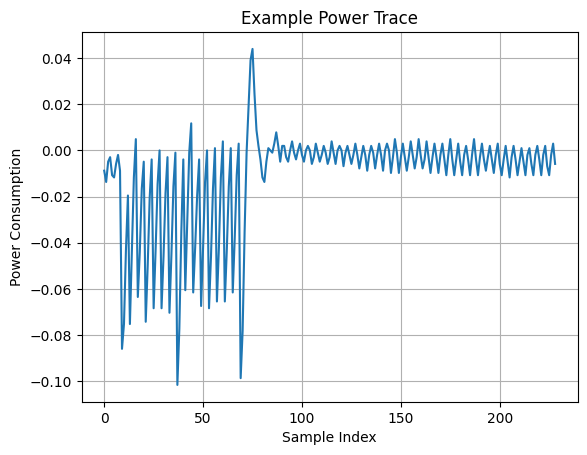

In [12]:
import matplotlib.pyplot as plt

plt.plot(traces[9])
plt.title("Example Power Trace")
plt.xlabel("Sample Index")
plt.ylabel("Power Consumption")
plt.grid(True)
plt.show()


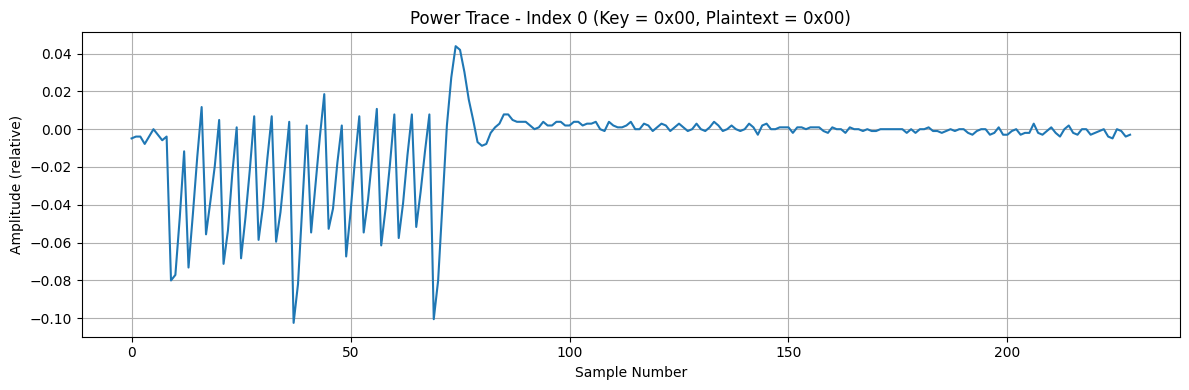

In [15]:
import pickle
import matplotlib.pyplot as plt

# Load traces (if already saved) - skip if traces are in memory
with open("traces_all.pkl", "rb") as f:
    traces = pickle.load(f)

# Plot the first trace
plt.figure(figsize=(12, 4))
plt.plot(traces[7])  # You can change the index to see other traces
plt.title("Power Trace - Index 0 (Key = 0x00, Plaintext = 0x00)")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude (relative)")
plt.grid(True)
plt.tight_layout()
plt.show()


Finally we save our traces and disconnect. By saving the traces, the attack can be repeated in the future without having to repeat the trace acquisition steps above.

## CPA Attack 
CPA attack on AES 256 using the MATLAB code Samarth gave which was written by Prof. Debayan


In [70]:
import numpy as np

# AES inverse S-box (standard values)
sbox_inv = np.array([
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38,
    0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87,
    0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D,
    0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2,
    0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16,
    0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA,
    0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A,
    0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02,
    0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA,
    0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85,
    0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89,
    0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20,
    0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31,
    0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D,
    0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0,
    0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26,
    0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D
], dtype=np.uint8)

np.save('sbox_inv.npy', sbox_inv)


In [71]:
import numpy as np
import matplotlib.pyplot as plt

def hamming_weight(x):
    return np.unpackbits(x.astype(np.uint8), axis=1).sum(axis=1)

def cpa_mtd_last_round(model, byte_to_attack, start_mtd, step_mtd, stop_mtd,
                       ciphertexts, traces, sbox_inv, key_byte, HW_table):

    INVSHIFT_UNDO = [0, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12, 1, 6, 11]
    K = np.arange(256, dtype=np.uint8)
    
    trace_length = traces.shape[1]
    trace_counts = np.arange(start_mtd, stop_mtd + 1, step_mtd)
    corr_amp = np.zeros((256, len(trace_counts)))

    for idx, sample_count in enumerate(trace_counts):
        print(f"Sample #: {sample_count}")

        ct = ciphertexts[:sample_count, byte_to_attack]
        V0 = np.tile(ct[:, np.newaxis], (1, 256))

        V1_index = INVSHIFT_UNDO[byte_to_attack]
        V1 = ciphertexts[:sample_count, V1_index]
        V1 = np.tile(V1[:, np.newaxis], (1, 256)).astype(np.int64)

        V2 = sbox_inv[np.bitwise_xor(V0, K[np.newaxis, :])]
        V = np.bitwise_xor(V1, V2)

        if model == 1:  # Hamming Weight model
            H = HW_table[V]
            analyzed_traces = traces[:sample_count]
            R = np.corrcoef(H.T, analyzed_traces.T)[:256, 256:]
        elif model == 2:  # Hamming Distance model (successive ciphertexts)
            H = HW_table[np.bitwise_xor(V[:-1], V[1:])]
            analyzed_traces = traces[1:sample_count]
            R = np.corrcoef(H.T, analyzed_traces.T)[:256, 256:]
        else:
            raise ValueError("Invalid leakage model")

        corr_amp[:, idx] = np.max(np.abs(R), axis=1)
        
    return corr_amp

    # Print top keys per iteration and determine MTD
    mtd = 0
    for i, count in enumerate(trace_counts):
        sorted_indices = np.argsort(-corr_amp[:, i])
        top_keys = sorted_indices[:5]
        print(f"Top 5 Keys in iteration {i+1} (traces={count}): {top_keys}")
        if key_byte in top_keys and mtd == 0:
            mtd = count

    print(f"\nMTD (Minimal Traces to Discover Key): {mtd}")
    return mtd


In [72]:
    # # Plotting MTD curve
    # plt.figure()
    # for key_guess in range(256):
    #     plt.plot(trace_counts, corr_amp[key_guess], color='c', alpha=0.3)

    # key_byte = 27
    # plt.plot(trace_counts, corr_amp[key_byte], color='r', label='Correct Key')
    # plt.plot(trace_counts, corr_amp[27], color='g', label='Key 27')  # Example
    # plt.title(f'MTD for Key Byte {byte_to_attack}')
    # plt.xlabel('Traces Analyzed')
    # plt.ylabel('Peak Correlation')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()


How `INVSHIFT_undo(byte_to_attack)` helps **retrace** the original byte location before AES’s **ShiftRows** in the last round?

---

### 🔁 What’s ShiftRows in AES?

In **AES encryption**, `ShiftRows` shifts bytes in each row of the state:

| Row | Shift |
|-----|-------|
| 0   | 0     |
| 1   | 1     |
| 2   | 2     |
| 3   | 3     |

So in **row-major** flat AES state (0–15), the byte indices shift as follows during `ShiftRows`:

```
Before:  [ 0  1  2  3   4  5  6  7   8  9 10 11  12 13 14 15 ]
After:   [ 0  5 10 15   4  9 14  3   8 13  2  7  12  1  6 11 ]
```

That’s why we define:

```matlab
INVSHIFT_undo = [0, 5, 10, 15,
                 4, 9, 14, 3,
                 8, 13, 2, 7,
                 12, 1, 6, 11];
```

This undoes the shift:  
`INVSHIFT_undo[after_index] = before_index`

---

### 🔙 So how does it *retract*?

Let’s say you are attacking:

```matlab
byte_to_attack = 7;
```

From the **ShiftRows table**, byte 7 came from byte index:

```matlab
INVSHIFT_undo(7) = 3
```

So to get the **correct input to the inverse S-box**, you need the byte from column 4 of the ciphertext:

```matlab
aes_ciphertexts(1:samples, INVSHIFT_undo(byte_to_attack) + 1);
```

(`+1` because MATLAB is 1-indexed)

---

### ✅ Summary:

If `byte_to_attack = X`, then:
```matlab
INVSHIFT_undo(X)
```
gives you the **original byte index** *before* ShiftRows — the one that contributed to that position after decryption's `InvShiftRows`. This is necessary to compute the correct internal state when performing CPA on the **last round** of AES.

Let me know if you'd like a simple visual map of how bytes move during `ShiftRows`!


The line:

```matlab
V1 = aes_ciphertexts(1:samples, INVSHIFT_undo(byte_to_attack) + 1);
```

gives you a **1D column vector** of size `[samples x 1]`. Here's what it's doing:

---

### 📌 Explanation:

- `aes_ciphertexts` is a 2D matrix of shape `[number_of_traces x 16]`, where each row is a ciphertext with 16 bytes (AES block size).
- `1:samples` selects the first `samples` number of ciphertexts (i.e., rows).
- `INVSHIFT_undo(byte_to_attack) + 1` gives the column index of the aligned byte you want to use for the **inverse ShiftRows correction**.
    - The `+1` is needed because MATLAB arrays are 1-indexed.

---

### 🔢 Example:

Assume:
```matlab
samples = 4;
byte_to_attack = 0;
INVSHIFT_undo = [0, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12, 1, 6, 11];
aes_ciphertexts = [
  100 101 102 ... 115;
  200 201 202 ... 215;
  150 151 152 ... 165;
  250 251 252 ... 265
];  % [4 x 16] matrix
```

Then:
```matlab
V1 = aes_ciphertexts(1:4, INVSHIFT_undo(1) + 1);  % = aes_ciphertexts(1:4, 1)
```

So `V1 = [100; 200; 150; 250]` → shape `[4 x 1]` → a 1D **column vector**.

---

Let me know if you’d like to visualize this in Python or see how it’s used in correlation!

In [73]:
import numpy as np

traces = np.load("traces.npy")       # Shape: (num_traces, trace_length)
textin = np.load("textin.npy")       # Shape: (num_traces, 16) if AES
ciphertexts  = np.load("textout.npy")     # Shape: (num_traces, 16) if AES
sbox_inv = np.load('sbox_inv.npy')


Sample #: 0
Sample #: 200
Sample #: 400
Sample #: 600
Sample #: 800
Sample #: 1000

Top 5 key guesses at 0 traces: [255 254 253 252 251]

Top 5 key guesses at 200 traces: [ 45 232 133  92  99]

Top 5 key guesses at 400 traces: [126 113 103 173 239]

Top 5 key guesses at 600 traces: [126  94 173 113 190]

Top 5 key guesses at 800 traces: [104  72 113 102 232]
✔️ True key (104) found in top 5 at 800 traces.


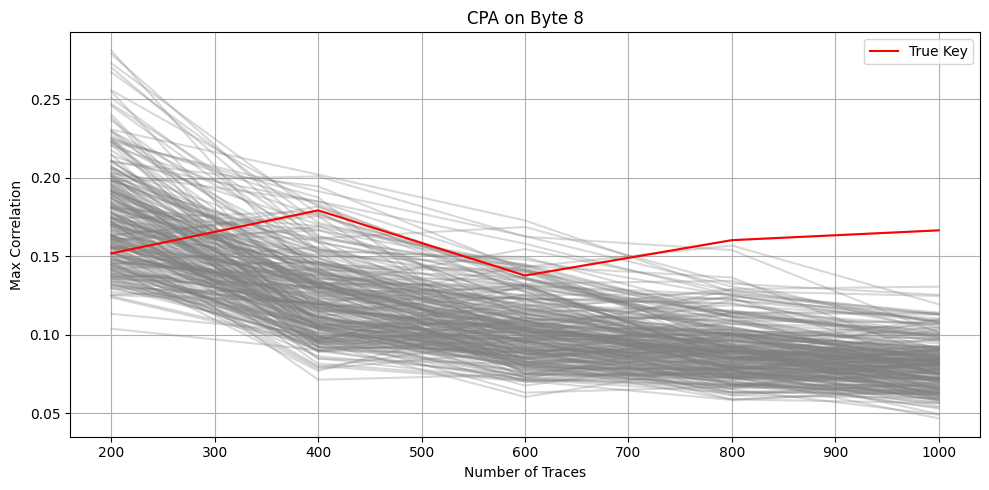

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Load your data
traces = np.load('traces.npy')
ciphertexts = np.load('textout.npy')
sbox_inv = np.load('sbox_inv.npy')

# Hamming Weight table
HW_table = np.array([bin(i).count("1") for i in range(256)])

# Parameters
model = 1  # 1 = HW, 2 = HD
byte_to_attack = 8  # Attack 1st byte
start_mtd = 0
step_mtd = 200
stop_mtd = 1000
true_key_byte = 104  # Replace with your actual key byte

# Call CPA function
corr_amp = cpa_mtd_last_round(
    model=model,
    byte_to_attack=byte_to_attack,
    start_mtd=start_mtd,
    step_mtd=step_mtd,
    stop_mtd=stop_mtd,
    ciphertexts=ciphertexts,
    traces=traces,
    sbox_inv=sbox_inv,
    key_byte=true_key_byte,
    HW_table=HW_table
)

# Get trace counts
trace_counts = np.arange(start_mtd, stop_mtd + 1, step_mtd)

# Find top key candidates at each step
for i, n_traces in enumerate(trace_counts):
    sorted_indices = np.argsort(corr_amp[:, i])[::-1]
    top5 = sorted_indices[:5]
    print(f"\nTop 5 key guesses at {n_traces} traces: {top5}")
    if true_key_byte in top5:
        print(f"✔️ True key ({true_key_byte}) found in top 5 at {n_traces} traces.")
        break

# Plot
plt.figure(figsize=(10, 5))
for k in range(256):
    plt.plot(trace_counts, corr_amp[k], color='gray', alpha=0.3)

plt.plot(trace_counts, corr_amp[true_key_byte], color='red', label='True Key')
plt.xlabel("Number of Traces")
plt.ylabel("Max Correlation")
plt.title(f"CPA on Byte {byte_to_attack}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## KNOWN VALUE CORRELATION

We have find the sample at which we got the maximmum correlation


In [81]:
import numpy as np

def known_value_correlation(traces, ciphertexts, true_key, sbox_inv, byte_idx, HW_table):
    INVSHIFT_UNDO = [0, 5, 10, 15,
                     4, 9, 14, 3,
                     8, 13, 2, 7,
                     12, 1, 6, 11]

    n_traces = traces.shape[0]# rows of traces i.e. no of traces = 7000
    n_points = traces.shape[1]# no of time samples in each trace i.e = 229 

    ct_b = ciphertexts[:, byte_idx]# ciphertexts are the no of traces = 7000 * no of bytes in a ciphertext whcih is 128 bits i.e 64 bytes
    # Byte_idx under attack is equal to the byte we are to recover 
    ct_invshift = ciphertexts[:, INVSHIFT_UNDO[byte_idx]]# This contains all the traces in the rows i.e 7000 rows and column of the byte under attack

    # Compute internal state
    v2 = sbox_inv[np.bitwise_xor(ct_b, true_key[byte_idx])]
    v = np.bitwise_xor(ct_invshift, v2)

    # Compute leakage model
    hw = HW_table[v]

    # Correlate model with traces
    corr = np.corrcoef(hw, traces.T)[0, 1:]

    return corr


 **Correlation Power Analysis (CPA)** in Python. Let me explain exactly what's happening:

```python
corr = np.corrcoef(hw, traces.T)[0, 1:]
```

### Components:

1. **`hw`**:  
   - This is your **hypothetical power consumption model** for one key guess.  
   - It’s typically a 1D array of Hamming Weights (length = number of traces).

2. **`traces.T`**:  
   - Transposes your trace matrix.  
   - If `traces` is of shape `(num_traces, num_samples)`, then `traces.T` is `(num_samples, num_traces)`.  
   - Each **row** of `traces.T` is the power values at one sample point across all traces.

3. **`np.corrcoef(hw, traces.T)`**:  
   - This calculates the **Pearson correlation coefficients** between `hw` and each row of `traces.T`, i.e., between your model and each sample point.

4. **`[0, 1:]`**:  
   - The full result of `np.corrcoef(hw, traces.T)` is a 2D matrix.  
   - `[0, 1:]` extracts the correlations between `hw` and all the samples, resulting in a 1D array of correlation values — one per sample.

---

### Final Output:
- `corr` is a vector of length `num_samples`.
- Each value is the correlation between the model and the power consumption at that sample point.

### Why this is important:
This helps identify **which sample point** correlates the strongest with your key hypothesis — a peak usually reveals the correct key byte.

Want a toy example to visualize this in action?

In [82]:
import numpy as np

# Your last round key in hex
last_round_key_hex = "de327c5fdaee30306848e7315b0daf34"
print(last_round_key_hex)
# Convert to an array of bytes
last_round_key_bytes = np.frombuffer(bytes.fromhex(last_round_key_hex), dtype=np.uint8)

print(last_round_key_bytes)


de327c5fdaee30306848e7315b0daf34
[222  50 124  95 218 238  48  48 104  72 231  49  91  13 175  52]


[222  50 124  95 218 238  48  48 104  72 231  49  91  13 175  52]


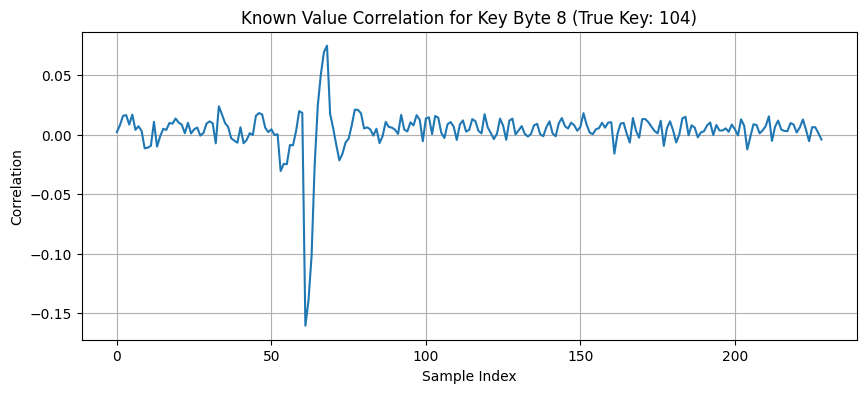

In [85]:
# Load data (assuming these are already loaded in your environment)
# traces = np.load('traces.npy')
# ciphertexts = np.load('textout.npy')
# sbox_inv = np.load('sbox_inv.npy')

# Convert last round key hex to byte array if not already
last_round_key_hex = "de327c5fdaee30306848e7315b0daf34"
true_key = np.frombuffer(bytes.fromhex(last_round_key_hex), dtype=np.uint8)
print(true_key)
# Define the Hamming weight table if not defined yet
HW_table = np.array([bin(i).count("1") for i in range(256)])

# Choose which byte you want to attack
byte_idx = 8 # for example, attacking byte 0 of the last round key

# Run known value correlation
corr = known_value_correlation(traces, ciphertexts, true_key, sbox_inv, byte_idx, HW_table)

# Plot the correlation
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(corr)
plt.title(f'Known Value Correlation for Key Byte {byte_idx} (True Key: {true_key[byte_idx]})')
plt.xlabel('Sample Index')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()


In [86]:
max_idx = np.argmax(np.abs(corr))
max_corr = corr[max_idx]

print(f"Maximum correlation at sample index: {max_idx}")
print(f"Correlation value: {max_corr:.5f}")


Maximum correlation at sample index: 61
Correlation value: -0.16038


In [87]:
# Only consider positive correlations
max_idx = np.argmax(corr)  # No np.abs here
max_corr = corr[max_idx]

print(f"📈 Maximum positive correlation at sample index: {max_idx}")
print(f"Correlation value: {max_corr:.5f}")


📈 Maximum positive correlation at sample index: 68
Correlation value: 0.07454


## Document Analysis: MATLAB Code analysis of CPA attack on AES-256

<figure style="text-align: center;">
  <img src="AES_CPA_Attack_KnownValueCorrelation_1.jpg" alt="AES CPA Flowchart" width="600">
  <figcaption>Figure 1: Step-by-step AES CPA Attack diagram.</figcaption>
</figure>

<figure style="text-align: center;">
  <img src="AES_CPA_Attack_KnownValueCorrelation_2.jpg" alt="AES CPA Flowchart" width="600">
  <figcaption>Figure 2: Step-by-step AES CPA Attack diagram.</figcaption>
</figure>

<figure style="text-align: center;">
  <img src="AES_CPA_Attack_KnownValueCorrelation.jpg" alt="AES CPA Flowchart" width="600">
  <figcaption>Figure 3: Step-by-step AES CPA Attack diagram.</figcaption>
</figure>


## KNOWN VALUE CORRELATION 

<figure style="text-align: center;">
  <img src="AES_CPA_Attack_KnownValueCorrelation_4.jpg" alt="AES CPA Flowchart" width="600">
  <figcaption>Figure 4: Known Value Correlation.</figcaption>
</figure>


<figure style="text-align: center;">
  <img src="AES_CPA_Attack_KnownValueCorrelation_5.jpg" alt="AES CPA Flowchart" width="600">
  <figcaption>Figure 5: Known Value Correlation.</figcaption>
</figure>
